<a href="https://colab.research.google.com/github/yankikalfa/MGTF-405-Business-Forecasting/blob/main/Assignment_3_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 Starter Code

In [ ]:
#! pip install statsmodels -U

In [ ]:
#! pip install arch

## Packages and Data

In [ ]:
import numpy as np
import pandas as pd 
import os as os
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.formula.api as smf
from arch import arch_model
from arch.univariate import ARCH, GARCH,EGARCH
import warnings
warnings.filterwarnings("ignore")
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

In [ ]:
sm.__version__

'0.13.2'

In [ ]:
os.getcwd()

'c:\\Users\\yanki\\Dropbox\\forecasting\\2022\\Assignmnent 3'

In [ ]:
hk = pd.read_excel('HongKong_property_index_combined_2022.xlsx',parse_dates=True, index_col=0)
hk.asfreq('M')
btc= pd.read_excel('BTC-USD.xlsx',parse_dates=True, index_col=0)

## Part 1

### Data Description, Transformation, and Tests 

In [ ]:
hk.head()

,Hong Kong Property index,Hong Kong CPI,Hong Kong 5-yr govt yield,Hong Kong unemployment rate,HK-US dollar exchange rate
Date,,,,,
1994-09-30,16973.6992,68.626214,7.86,2.3,7.7273
1994-10-31,17219.2988,69.276699,8.16,2.3,7.7275
1994-11-30,14475.3994,69.683252,8.36,2.3,7.7344
1994-12-31,13523.3994,70.252427,8.42,1.9,7.7375
1995-01-31,12246.7002,70.658981,8.59,1.9,7.7355


In [ ]:
hk.rename(columns={'Hong Kong Property index':'HKPI','Hong Kong CPI':'HKCPI','Hong Kong 5-yr govt yield':'HK5YR','Hong Kong unemployment rate':'HKURATE','HK-US dollar exchange rate':'HKXR'},inplace=True)

In [ ]:
hk['dhkpi'] = (np.log(hk['HKPI'])-np.log(hk['HKPI'].shift(1)))*100
hk['hkinfl'] = (np.log(hk['HKCPI'])-np.log(hk['HKCPI'].shift(1)))*100
hk['hkusd']  = (np.log(hk['HKXR'])-np.log(hk['HKXR'].shift(1)))*100
hk['hkinfl_1'] = hk['hkinfl'].shift(1)
hk['HKURATE_1'] = hk['HKURATE'].shift(1)
hk['HK5YR_1'] = hk['HK5YR'].shift(1)
hk['hkusd_1'] = hk['hkusd'].shift(1)
hk.dropna(inplace=True)

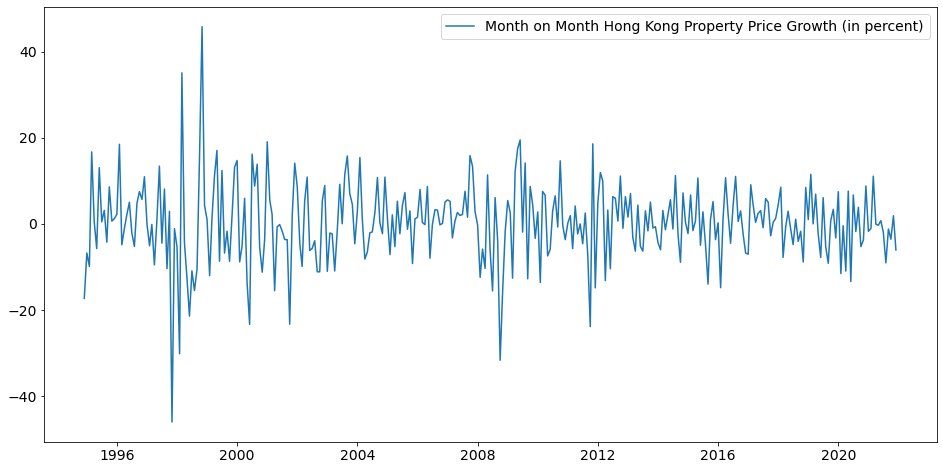

In [ ]:
plt.plot(hk['dhkpi'],label='Month on Month Hong Kong Property Price Growth (in percent)')
plt.legend()
plt.savefig('dhkpi.png', format='png')

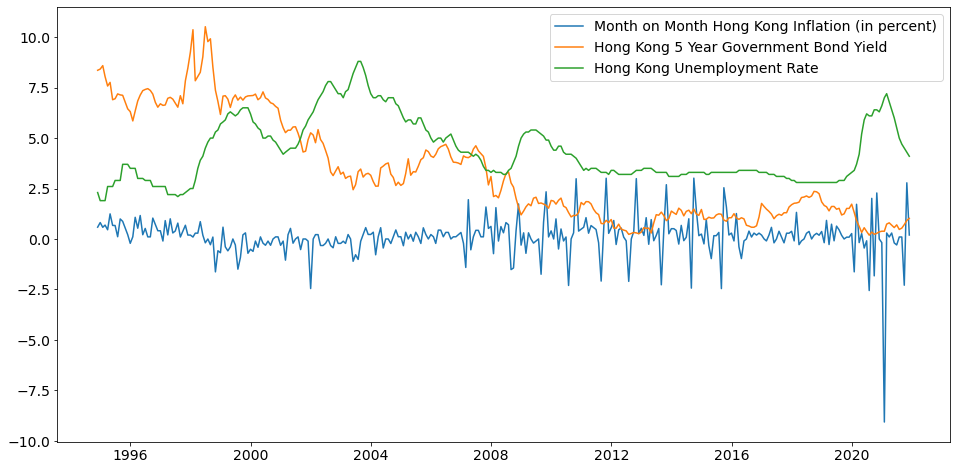

In [ ]:
plt.plot(hk['hkinfl'],label='Month on Month Hong Kong Inflation (in percent)')
plt.plot(hk['HK5YR'],label='Hong Kong 5 Year Government Bond Yield')
plt.plot(hk['HKURATE'],label='Hong Kong Unemployment Rate')
plt.legend()



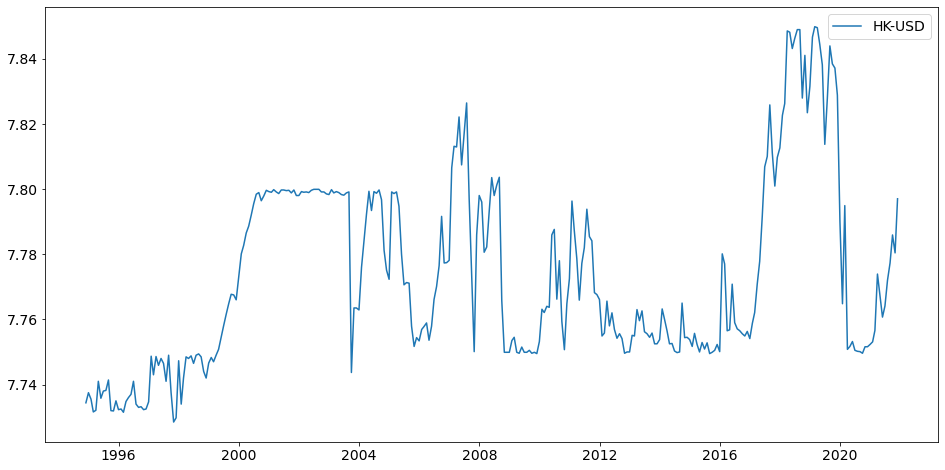

In [ ]:
plt.plot(hk['HKXR'],label='HK-USD')
plt.legend()

In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [ ]:
adf_test(hk['dhkpi'].dropna())


Results of Dickey-Fuller Test:
Test Statistic                -1.774062e+01
p-value                        3.403438e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.240000e+02
Critical Value (1%)           -3.450695e+00
Critical Value (5%)           -2.870502e+00
Critical Value (10%)          -2.571545e+00
dtype: float64


In [ ]:
adf_test(hk['hkinfl'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -2.403012
p-value                          0.140888
#Lags Used                      11.000000
Number of Observations Used    313.000000
Critical Value (1%)             -3.451416
Critical Value (5%)             -2.870819
Critical Value (10%)            -2.571714
dtype: float64


In [ ]:
adf_test(hk['HK5YR'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.385864
p-value                          0.589034
#Lags Used                       7.000000
Number of Observations Used    317.000000
Critical Value (1%)             -3.451148
Critical Value (5%)             -2.870701
Critical Value (10%)            -2.571651
dtype: float64


In [ ]:
adf_test(hk['HKXR'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.209188
p-value                          0.019459
#Lags Used                       0.000000
Number of Observations Used    324.000000
Critical Value (1%)             -3.450695
Critical Value (5%)             -2.870502
Critical Value (10%)            -2.571545
dtype: float64


In [ ]:
adf_results_tstat={}
for col in hk.columns.values:
    adf_results_tstat[col] = adfuller(hk[col],regression='c',autolag='AIC')[0]

adf_results_pval={}
for col in hk.columns.values:
    adf_results_pval[col] = adfuller(hk[col],regression='c',autolag='AIC')[1]

adf_results_lags={}
for col in hk.columns.values:
    adf_results_lags[col] = adfuller(hk[col],regression='c',autolag='AIC')[2]

adf_results_tstat=pd.DataFrame.from_dict(adf_results_tstat, orient='index')
adf_results_pval=pd.DataFrame.from_dict(adf_results_pval, orient='index')
adf_results_lags=pd.DataFrame.from_dict(adf_results_lags, orient='index')
adf_results=pd.concat([adf_results_tstat,adf_results_pval,adf_results_lags],axis=1)
adf_results.to_csv('adf_results.csv')

### Question 1

In [ ]:
def AIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any value between 0 and 2
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
      try:
          mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=True,
                      enforce_invertibility=True)
          
          output = mod.fit()
          ans.append([comb, output.aic])
          print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
      except:
        continue
# Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df

In [ ]:
def BIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any user defined value. We need to be careful with integration order,
# cannot be 0.
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
      try:
          mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=True,
                      enforce_invertibility=True)
          
          output = mod.fit()
          ans.append([comb, output.aic])
          print('ARIMA {} x {}12 : BIC Calculated ={}'.format(comb, output.bic))
      except:
        continue
# Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'bic'])
    print(ans_df.loc[ans_df['bic'].idxmin()])
    return ans_df

In [ ]:
aic_12 = AIC_PDQ(hk['dhkpi'],12,1,12)
aic_6 = AIC_PDQ(hk['dhkpi'],6,1,6)
bic_12 = BIC_PDQ(hk['dhkpi'],12,1,12)
bic_6 = BIC_PDQ(hk['dhkpi'],6,1,6)


pdq      (1, 0, 1)
aic    2362.602504
Name: 13, dtype: object
pdq      (1, 0, 1)
aic    2362.602504
Name: 7, dtype: object
pdq      (1, 0, 1)
bic    2362.602504
Name: 13, dtype: object
pdq      (1, 0, 1)
bic    2362.602504
Name: 7, dtype: object


It appears that we get the same result for AIC and BIC.
Let's try 

In [ ]:
model_hkpi11 = ARIMA(hk['dhkpi'], order=(1,0,1)).fit()


In [ ]:
model_hkpi11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  dhkpi   No. Observations:                  325
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1177.301
Date:                Wed, 16 Feb 2022   AIC                           2362.603
Time:                        12:24:55   BIC                           2377.738
Sample:                    11-30-1994   HQIC                          2368.643
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2910      0.089      3.275      0.001       0.117       0.465
ar.L1          0.9284      0.021     44.232      0.000       0.887       0.970
ma.L1         -0.9999      1.771     -0.565      0.572      -4.470       2.470
sigma2        81.3885    142.951      0.569      0.569    -198.790     361.567
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):               159.94
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This is to export results to excel.

In [ ]:
res_arma11 = pd.concat((model_hkpi11.params, model_hkpi11.tvalues,model_hkpi11.pvalues), axis=1)
res_arma11=res_arma11.rename(columns={0: 'Coefficient', 1: 'T-stat',2:'P-Values'})
res_arma11.to_excel('ARMA11_res.xlsx', 'sheet1')

In [ ]:
res_arma11

,Coefficient,T-stat,P-Values
const,0.290976,3.275189,0.001056
ar.L1,0.928428,44.231830,0.000000
ma.L1,-0.999919,-0.564739,0.572251
sigma2,81.388461,0.569347,0.569121


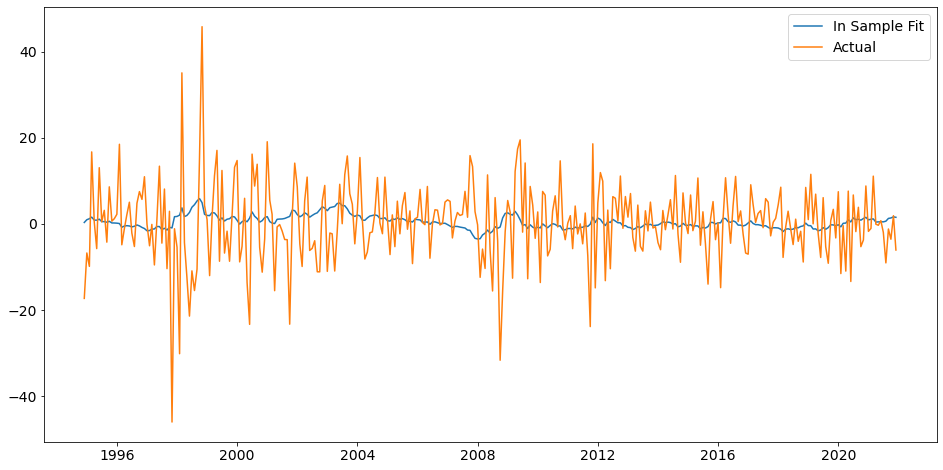

In [ ]:
plt.plot(model_hkpi11.fittedvalues, label ='In Sample Fit')
plt.plot(hk['dhkpi'], label= 'Actual')
plt.legend()
plt.savefig('arma11_fit.png', format='png')

In [ ]:
hk

,HKPI,HKCPI,HK5YR,HKURATE,HKXR,dhkpi,hkinfl,hkusd,hkinfl_1,HKURATE_1,HK5YR_1,hkusd_1
Date,,,,,,,,,,,,
1994-11-30,14475.3994,69.683252,8.360,2.3,7.7344,-17.358016,0.585139,0.089252,0.943403,2.3,8.160,0.002588
1994-12-31,13523.3994,70.252427,8.420,1.9,7.7375,-6.802914,0.813485,0.040073,0.585139,2.3,8.360,0.089252
1995-01-31,12246.7002,70.658981,8.590,1.9,7.7355,-9.916494,0.577036,-0.025851,0.813485,1.9,8.420,0.040073
1995-02-28,14470.5000,71.146845,8.050,1.9,7.7316,16.685557,0.688076,-0.050430,0.577036,1.9,8.590,-0.025851
1995-03-31,14532.7988,71.472087,7.580,2.6,7.7321,0.429599,0.456101,0.006467,0.688076,1.9,8.050,-0.050430
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31,31831.3400,101.400000,0.472,5.0,7.7720,-9.105880,0.098668,0.101699,-0.295712,5.5,0.699,0.043801
2021-08-31,31441.8500,101.500000,0.538,4.7,7.7773,-1.231153,0.098571,0.068170,0.098668,5.0,0.472,0.101699
2021-09-30,30328.3500,99.200000,0.710,4.5,7.7859,-3.605689,-2.292078,0.110517,0.098571,4.7,0.538,0.068170


### Question 2

In [ ]:
exog = hk.iloc[:,8:]

In [ ]:
armax11 = sm.tsa.statespace.SARIMAX(hk['dhkpi'].dropna(),trend='c',order=(1,0,1), exog=exog).fit()
armax11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  dhkpi   No. Observations:                  325
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1180.521
Date:                Wed, 16 Feb 2022   AIC                           2377.042
Time:                        12:24:56   BIC                           2407.312
Sample:                    11-30-1994   HQIC                          2389.123
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.6157      5.786     -0.452      0.651     -13.956       8.725
hkinfl_1       0.1387      0.565      0.246      0.806      -0.968       1.246
HKURATE_1      0.4832      0.381      1.268      0.205      -0.263       1.230
HK5YR_1       -0.0065      0.172     -0.038      0.970      -0.345       0.332
hkusd_1       -3.3653      4.710     -0.715      0.475     -12.597       5.866
ar.L1         -0.3539      2.700     -0.131      0.896      -5.647       4.939
ma.L1          0.3677      2.695      0.136      0.891      -4.914       5.649
sigma2        83.6709      4.117     20.321      0.000      75.601      91.741
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               206.11
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It appears that no variables are significant

In [ ]:
res_armax11 = pd.concat((armax11.params, armax11.tvalues,armax11.pvalues), axis=1)
res_armax11=res_armax11.rename(columns={0: 'Coefficient', 1: 'T-stat',2:'P-Values'})
res_armax11.to_excel('ARMAX11_res.xlsx', 'sheet1')
res_armax11

,Coefficient,T-stat,P-Values
intercept,-2.615726,-0.452080,6.512112e-01
hkinfl_1,0.138747,0.245664,8.059425e-01
HKURATE_1,0.483182,1.268342,2.046758e-01
HK5YR_1,-0.006501,-0.037690,9.699350e-01
hkusd_1,-3.365347,-0.714527,4.749012e-01
ar.L1,-0.353907,-0.131056,8.957311e-01
ma.L1,0.367684,0.136441,8.914726e-01
sigma2,83.670894,20.321451,8.308454e-92


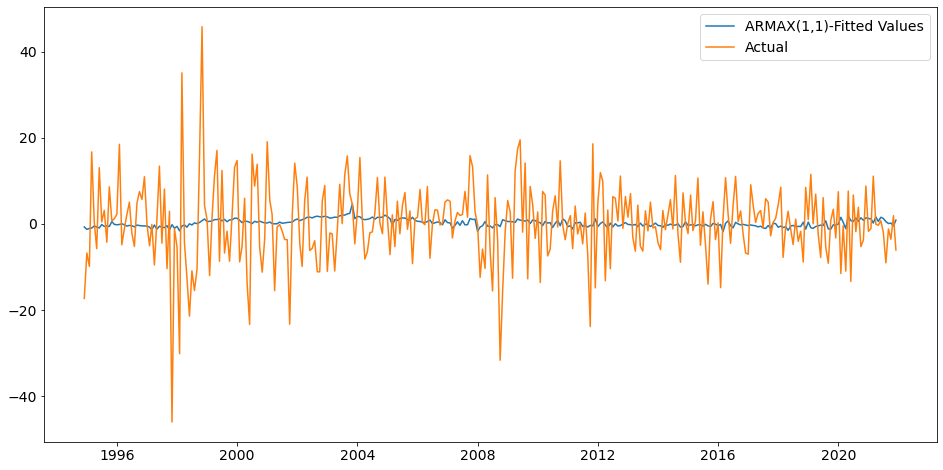

In [ ]:
plt.plot(armax11.fittedvalues, label='ARMAX(1,1)-Fitted Values')
plt.plot(hk['dhkpi'], label='Actual')
plt.legend()
plt.savefig('armax_fit.png',format='png')


### Questions 3-5

In [ ]:
train_data = hk[['dhkpi', 'HK5YR', 'HKURATE', 'HKXR']]
train_data

,dhkpi,HK5YR,HKURATE,HKXR
Date,,,,
1994-11-30,-17.358016,8.360,2.3,7.7344
1994-12-31,-6.802914,8.420,1.9,7.7375
1995-01-31,-9.916494,8.590,1.9,7.7355
1995-02-28,16.685557,8.050,1.9,7.7316
1995-03-31,0.429599,7.580,2.6,7.7321
...,...,...,...,...
2021-07-31,-9.105880,0.472,5.0,7.7720
2021-08-31,-1.231153,0.538,4.7,7.7773
2021-09-30,-3.605689,0.710,4.5,7.7859


In [ ]:
VARmodel_1 = VAR(train_data).fit(maxlags=1, ic='aic')
VARmodel_2 = VAR(train_data).fit(maxlags=2, ic='aic')
VARmodel_12= VAR(train_data).fit(maxlags=12, ic='aic')


In [ ]:
VARmodel_1.aic,VARmodel_2.aic

(-10.199187463881447, -10.60383287303923)

In [ ]:
VARmodel_2.k_ar

2

In [ ]:
VARmodel_2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Feb, 2022
Time:                     12:24:57
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -10.1828
Nobs:                     323.000    HQIC:                  -10.4358
Log likelihood:          -84.7496    FPE:                2.48221e-05
AIC:                     -10.6038    Det(Omega_mle):     2.22381e-05
--------------------------------------------------------------------
Results for equation dhkpi
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const            119.090060       146.062135            0.815           0.415
L1.dhkpi           0.008333         0.060017            0.139           0.890
L1.HK5YR           0.365753         1.546330            0.237           

In [ ]:
var2_dhkpi=pd.concat([VARmodel_2.params.iloc[:,0], VARmodel_2.tvalues.iloc[:,0],VARmodel_2.pvalues.iloc[:,0]],axis=1)
var2_dhkpi.columns = ['Coefficient', 'T-Stats','P-Values']
var2_hk5yr=pd.concat([VARmodel_2.params.iloc[:,1], VARmodel_2.tvalues.iloc[:,1],VARmodel_2.pvalues.iloc[:,1]],axis=1)
var2_hk5yr.columns = ['Coefficient', 'T-Stats','P-Values']
var2_hkurate=pd.concat([VARmodel_2.params.iloc[:,2], VARmodel_2.tvalues.iloc[:,2],VARmodel_2.pvalues.iloc[:,2]],axis=1)
var2_hkurate.columns = ['Coefficient', 'T-Stats','P-Values']
var2_hkxr=pd.concat([VARmodel_2.params.iloc[:,3], VARmodel_2.tvalues.iloc[:,3],VARmodel_2.pvalues.iloc[:,3]],axis=1)
var2_hkxr.columns = ['Coefficient', 'T-Stats','P-Values']
pd.concat([var2_dhkpi,var2_hk5yr,var2_hkurate, var2_hkxr],axis=0).to_csv('varres.csv')



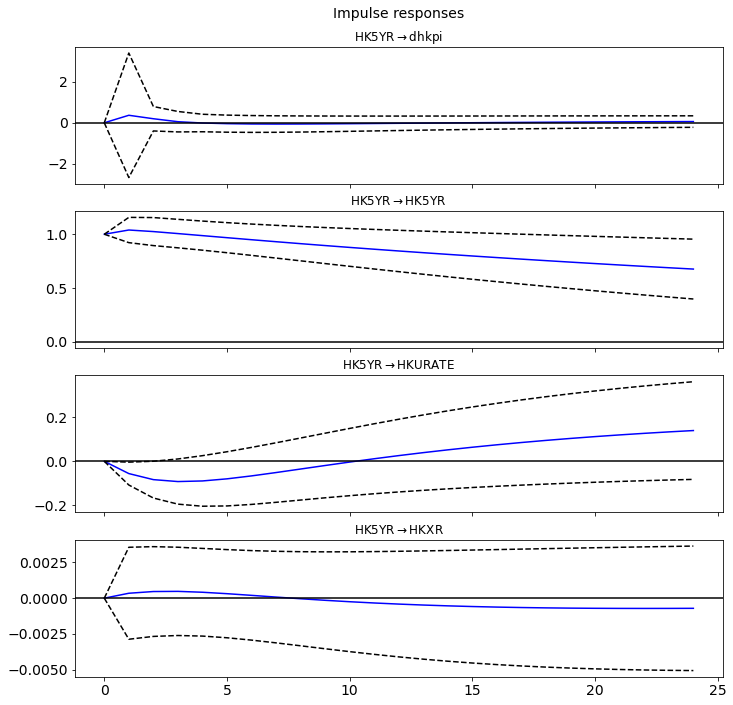

In [ ]:
irf = VARmodel_2.irf(24)
irf.plot(impulse = 'HK5YR')
plt.savefig('hk5yr_impulse.png',format='png')

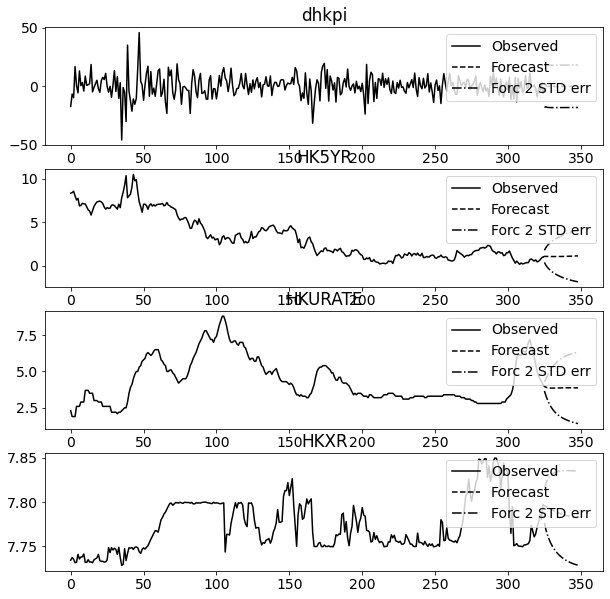

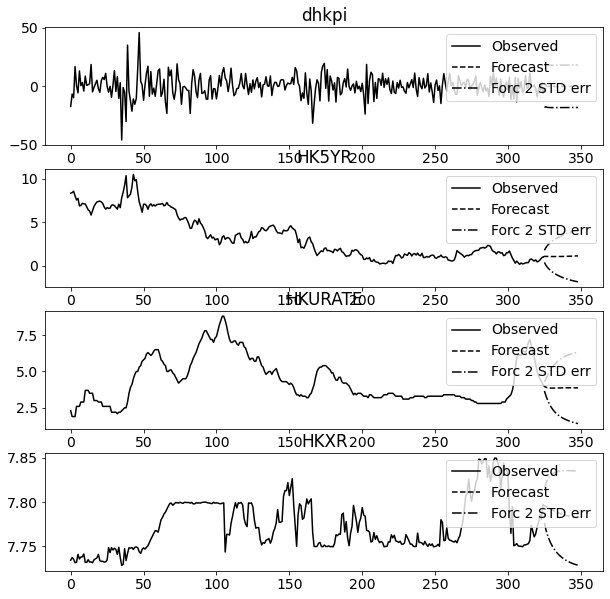

In [ ]:
VARmodel_2.plot_forecast(24)

In [ ]:
point_forecasts=pd.DataFrame(VARmodel_2.forecast_interval(train_data.values[-2:],24)[0])
forecast_l = pd.DataFrame(VARmodel_2.forecast_interval(train_data.values[-2:],24)[1])
forecast_u = pd.DataFrame(VARmodel_2.forecast_interval(train_data.values[-2:],24)[2])


In [ ]:
point_forecasts.rename(columns={0:'dhkpi_forecast',1:'HK5YR_forecast',2:'HKURATE_forecast',3:'HKXR_forecast'},inplace=True)
point_forecasts.set_index(pd.date_range("2021-12-30",periods=24,freq='M'),inplace=True)

forecast_l.rename(columns={0:'dhkpi-2std',1:'HK5YR-2std',2:'HKURATE-2std',3:'HKXR-2std'},inplace=True)
forecast_l.set_index(pd.date_range("2021-12-30",periods=24,freq='M'),inplace=True)

forecast_u.rename(columns={0:'dhkpi+2std',1:'HK5YR+2std',2:'HKURATE+2std',3:'HKXR+2std'},inplace=True)
forecast_u.set_index(pd.date_range("2021-12-30",periods=24,freq='M'),inplace=True)



In [ ]:
forecast_df=pd.concat([train_data,point_forecasts,forecast_l, forecast_u],axis=1)

In [ ]:
forecast_df

,dhkpi,HK5YR,HKURATE,HKXR,dhkpi_forecast,HK5YR_forecast,HKURATE_forecast,HKXR_forecast,dhkpi-2std,HK5YR-2std,HKURATE-2std,HKXR-2std,dhkpi+2std,HK5YR+2std,HKURATE+2std,HKXR+2std
1994-11-30,-17.358016,8.36,2.3,7.7344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-12-31,-6.802914,8.42,1.9,7.7375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-31,-9.916494,8.59,1.9,7.7355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-28,16.685557,8.05,1.9,7.7316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-31,0.429599,7.58,2.6,7.7321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,NaN,NaN,NaN,NaN,-0.139492,1.131240,3.875243,7.783148,-18.312277,-1.669412,1.525907,7.730906,18.033294,3.931893,6.224579,7.835390
2023-08-31,NaN,NaN,NaN,NaN,-0.133804,1.138360,3.874505,7.782793,-18.307922,-1.710380,1.495132,7.730273,18.040314,3.987100,6.253877,7.835312
2023-09-30,NaN,NaN,NaN,NaN,-0.128641,1.145769,3.873578,7.782459,-18.303965,-1.748848,1.466496,7.729692,18.046683,4.040386,6.280660,7.835227
2023-10-31,NaN,NaN,NaN,NaN,-0.123958,1.153435,3.872497,7.782146,-18.300377,-1.784996,1.439789,7.729158,18.052461,4.091867,6.305205,7.835135


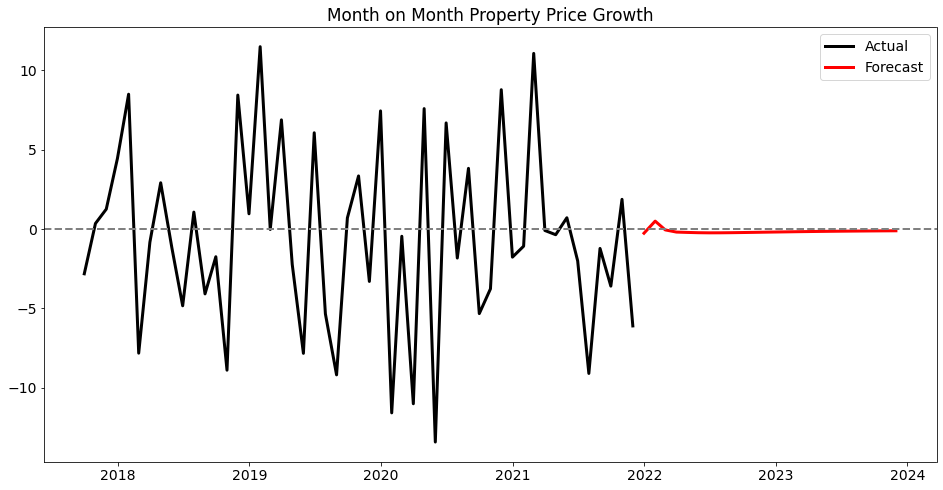

In [ ]:
plt.plot(forecast_df.iloc[-75:,0],label='Actual',color = 'k',lw=3)
plt.plot(forecast_df.iloc[-75:,4],label='Forecast',color='red',lw=3)
#plt.plot(forecast_df.iloc[-75:,8],label='-2 Std.Errors',linestyle = '--',color='k',lw=2)
#plt.plot(forecast_df.iloc[-75:,12],label='+2 Std.Errors',linestyle = '--',color='k',lw=2)
plt.axhline(y=0, color='grey', linestyle='--',lw=2)
plt.title('Month on Month Property Price Growth')
plt.legend()
plt.savefig('dhkpi-forecast.png',format='png')

## Part 2

### Questions 1 - 2

In [ ]:
btc['ret'] = np.log(btc['Close']/btc['Close'].shift(1))*100
btc['ret2'] = np.square(btc['ret'])
btc.dropna(inplace=True)

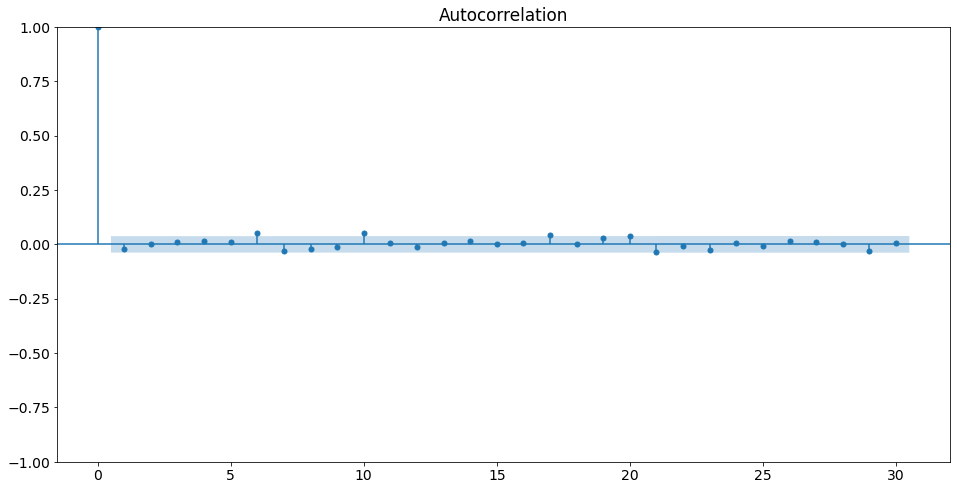

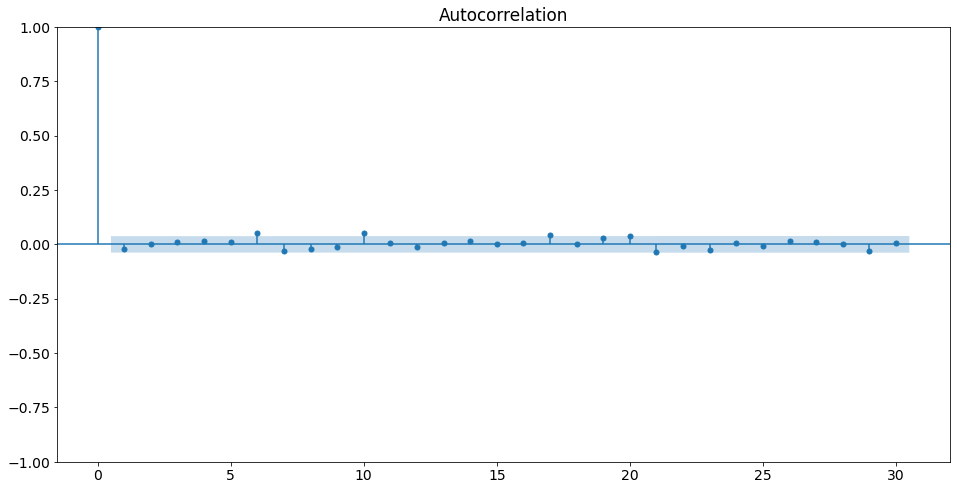

In [ ]:
sm.graphics.tsa.plot_acf(btc['ret'],lags=30)

The daily returns on Bitcoin do not seem to be autocorrelated

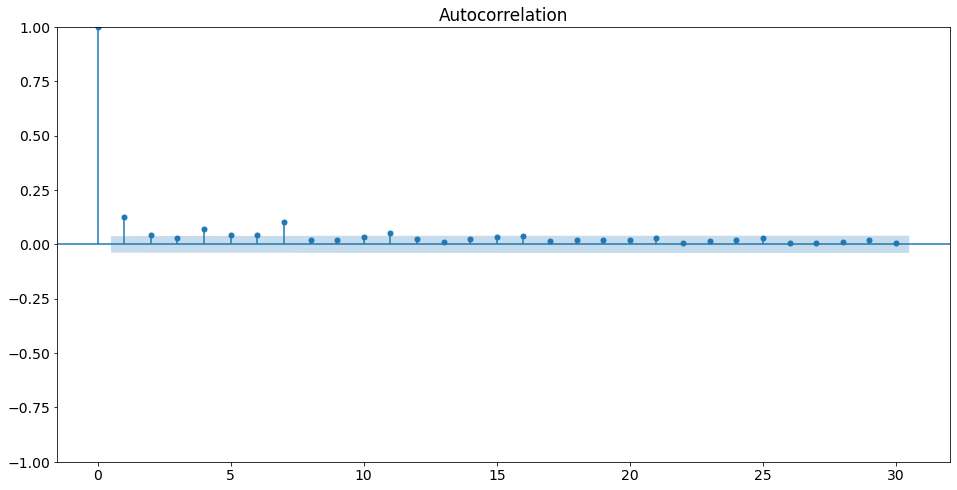

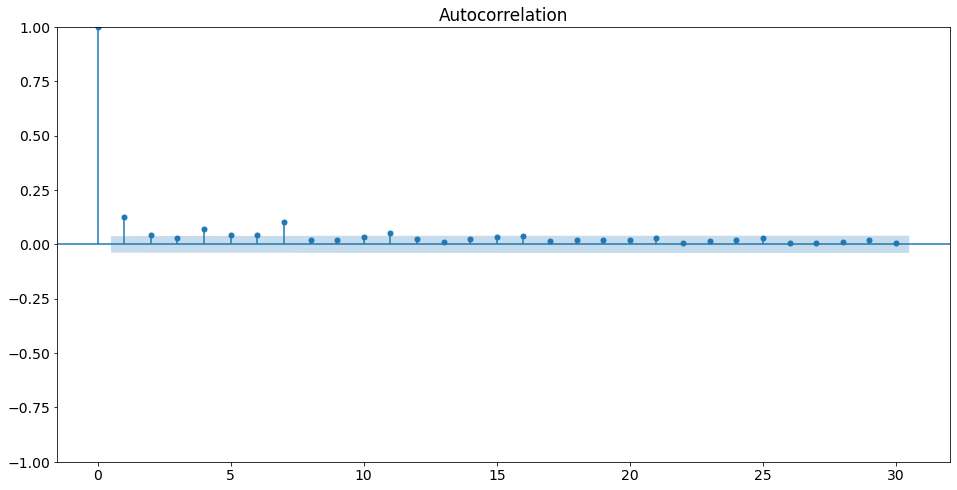

In [ ]:
sm.graphics.tsa.plot_acf(btc['ret2'],lags=30)

Squared Bitcoin returns seem to be autocorrelated. It also seems that there is some seasonal autocorrelation at the 1st and 7th lag. Which would mean at the weekly frequency.

### Question 3

In [ ]:
sm.stats.diagnostic.het_arch(btc['ret'],nlags=5)

(58.33584654900459,
 2.6815804591459986e-11,
 11.899635718518159,
 2.0705172111473923e-11)

In [ ]:
arch_test_pval=[]
for lags in range(1,30):
    arch_test_pval.append(round(sm.stats.diagnostic.het_arch(btc['ret'],nlags=lags)[1],4))

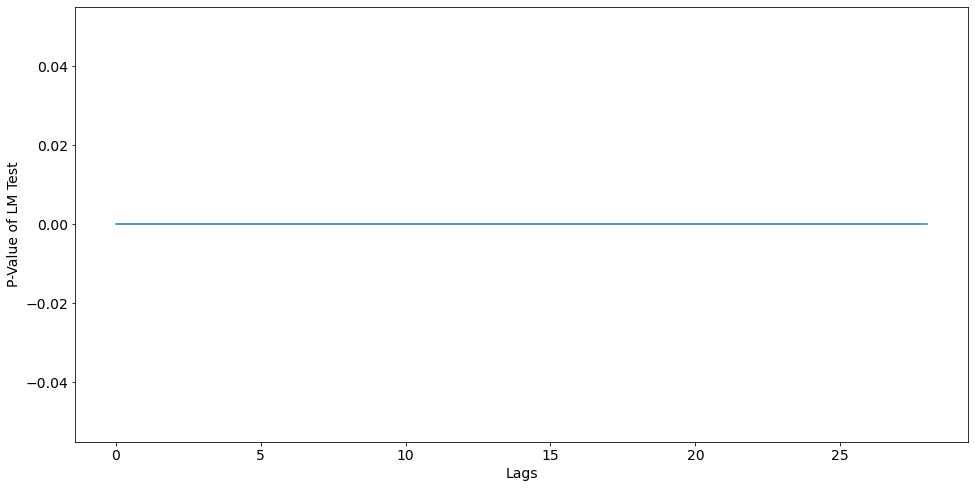

In [ ]:
# P-value of the ARCH Effects Test
plt.plot(arch_test_pval)
plt.xlabel('Lags')
plt.ylabel('P-Value of LM Test')
plt.savefig('arch_test.png',format='png')

### Question 4

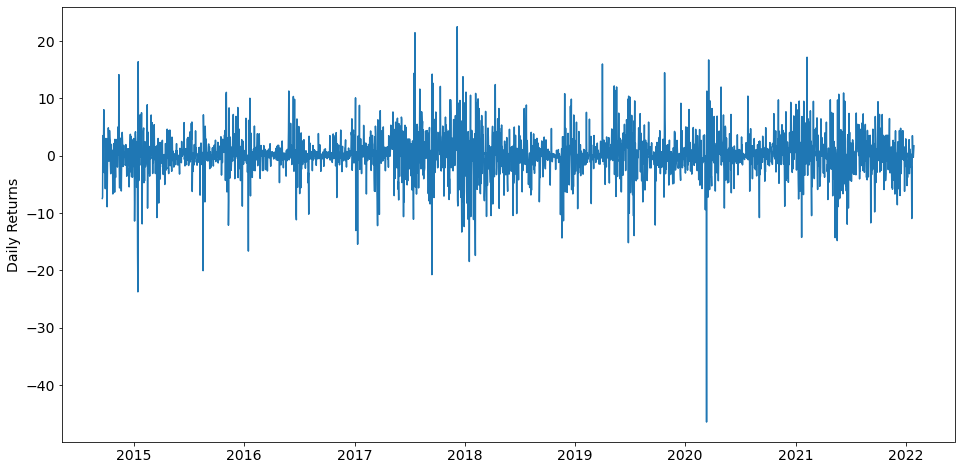

In [ ]:
plt.plot(btc['ret'])
plt.ylabel('Daily Returns')
plt.savefig('btc_daily_returns.png',format='png')

We need to make our underlying assumptions clear.

We will assume the normal distribution and fit a GARCH (1,1) to the daily returns.

In [ ]:
# This assumes a constant mean model
dist='normal'
#dist='t'
garch11 = arch_model(btc['ret'],p=1,q=1,o=0,dist=dist)
res_garch11 = garch11.fit(update_freq=10)

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7268.317625443097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7268.317625443097
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11


In [ ]:
garch11_results = pd.concat((round(res_garch11.params,4), round(res_garch11.tvalues,4),round(res_garch11.pvalues,4)), axis=1)
garch11_results=garch11_results.rename(columns={'params': 'Coefficient', 'tvalues': 'T-stat','pvalues':'P-Values'})
garch11_results.to_excel('GARCH11_res.xlsx', 'sheet1')
garch11_results

,Coefficient,T-stat,P-Values
mu,0.1901,2.8543,0.0043
omega,0.6931,2.7820,0.0054
alpha[1],0.1280,3.5616,0.0004
beta[1],0.8401,29.8045,0.0000


We can clearly see that volatilty is very persistent with a 0.13 coefficient on past shocks and 0.83 coefficient on lagged values of the variance of the shocks.

### Question 5

We will try to fit two other models, namely the GJR Garch and the EGARCH. You are more than welcome to use other models. 
https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html

In [ ]:
# This assumes a constant mean model
dist='normal'
#dist='t'
gjr11 = arch_model(btc['ret'],p=1,q=1,o=1,dist=dist)
res_gjr11 = gjr11.fit(update_freq=10)

Iteration:     10,   Func. Count:     72,   Neg. LLF: 7265.298224488453
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7265.162151461462
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


In [ ]:
egarch11 = arch_model(btc['ret'], p=1, o=0, q=1,vol='EGARCH',dist=dist)
res_egarch11 = egarch11.fit(update_freq=10)

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7260.241189457939
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7260.240085785302
            Iterations: 13
            Function evaluations: 79
            Gradient evaluations: 13


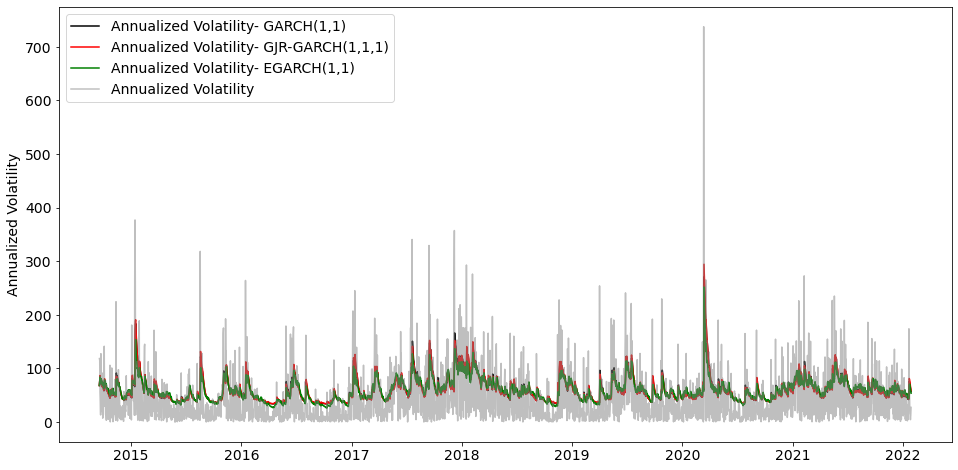

In [ ]:
plt.plot((res_garch11.conditional_volatility)*np.sqrt(252), label = 'Annualized Volatility- GARCH(1,1)',color='k')
plt.plot((res_gjr11.conditional_volatility)*np.sqrt(252), label = 'Annualized Volatility- GJR-GARCH(1,1,1)',color='red')
plt.plot((res_egarch11.conditional_volatility)*np.sqrt(252), label = 'Annualized Volatility- EGARCH(1,1)',color='green')
plt.plot(np.sqrt(btc['ret2'])*np.sqrt(252),alpha=0.5, label='Annualized Volatility',color='grey')
plt.legend()
plt.ylabel('Annualized Volatility')
plt.savefig('vol_model_fit.png',format='png')

In [ ]:
e_garch = np.square(np.sqrt(btc['ret2'])*np.sqrt(252) - (res_garch11.conditional_volatility)*np.sqrt(252)).rename('garch_errors',inplace=True)
e_gjr = np.square(np.sqrt(btc['ret2'])*np.sqrt(252) - (res_gjr11.conditional_volatility)*np.sqrt(252)).rename('gjr_errors',inplace=True)
e_egarch = np.square(np.sqrt(btc['ret2'])*np.sqrt(252) - (res_egarch11.conditional_volatility)*np.sqrt(252)).rename('egarch_errors',inplace=True)


round(np.mean(e_garch),2) ,round(np.mean(e_gjr),2),round(np.mean(e_egarch),2)


(2466.73, 2477.47, 2382.75)

From the models we try it appears that the EGARCH is performing better.

### Question 6

I like the EGARCH(1,1,1) model so I am going to do recursive 1-step ahead forecasting.

In [ ]:
btc.tail()

,Close,ret,ret2
Date,,,
2022-01-24,36654.32813,1.035297,1.071839
2022-01-25,36954.00391,0.814249,0.663001
2022-01-26,36852.12109,-0.276082,0.076222
2022-01-27,37138.23438,0.773384,0.598123
2022-01-28,37784.33203,1.724750,2.974764


............................
                  h.1
2021-12-31  55.370077
2022-01-01  56.247888
2022-01-02  53.649051
2022-01-03  53.620500
2022-01-04  52.300679
2022-01-05  59.309992
2022-01-06  56.688170
2022-01-07  59.977343
2022-01-08  55.500592
2022-01-09  51.644279
2022-01-10  48.738722
2022-01-11  49.023353
2022-01-12  50.521510
2022-01-13  53.407002
2022-01-14  51.210988
2022-01-15  47.643918
2022-01-16  45.122170
2022-01-17  46.503545
2022-01-18  43.564478
2022-01-19  44.113833
2022-01-20  46.759510
2022-01-21  69.392991
2022-01-22  71.087887
2022-01-23  70.663092
2022-01-24  65.736231
2022-01-25  61.164169
2022-01-26  57.092973
2022-01-27  53.679907


<AxesSubplot:title={'center':'Constant Mean(constant: yes, no. of exog: 0, volatility: EGARCH(p: 1, q: 1), distribution: Normal distribution)forecasts'}>

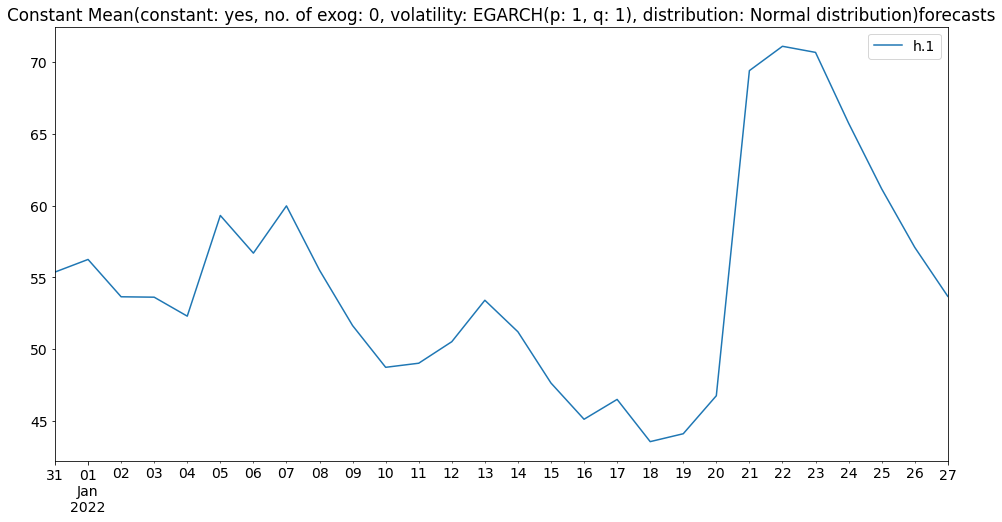

In [ ]:
import sys
index = btc.index
start_loc = 0
end_loc = np.where(index >= "2022-01-01")[0].min()
am= egarch11

forecasts = {}
for i in range(28):
    sys.stdout.write(".")
    sys.stdout.flush()
    res = am.fit(last_obs=i + end_loc, disp="off")
    temp = np.sqrt(res.forecast(horizon=1, reindex=False).variance)*np.sqrt(252)
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)
pd.DataFrame(forecasts).T.plot(title= f'{am}' 'forecasts')

In [ ]:
egarch_forecasts= pd.DataFrame(forecasts).T
egarch_forecasts.reset_index(drop=True,inplace=True)
egarch_forecasts.set_index(pd.date_range("2022-01-01",periods=28,freq='D'),inplace=True)
egarch_forecasts.rename(columns={'h.1':'Forecasts'},inplace=True)

In [ ]:
btc=pd.concat([btc,egarch_forecasts],axis=1)

In [ ]:
btc.tail()

,Close,ret,ret2,Forecasts
2022-01-24,36654.32813,1.035297,1.071839,70.663092
2022-01-25,36954.00391,0.814249,0.663001,65.736231
2022-01-26,36852.12109,-0.276082,0.076222,61.164169
2022-01-27,37138.23438,0.773384,0.598123,57.092973
2022-01-28,37784.33203,1.724750,2.974764,53.679907


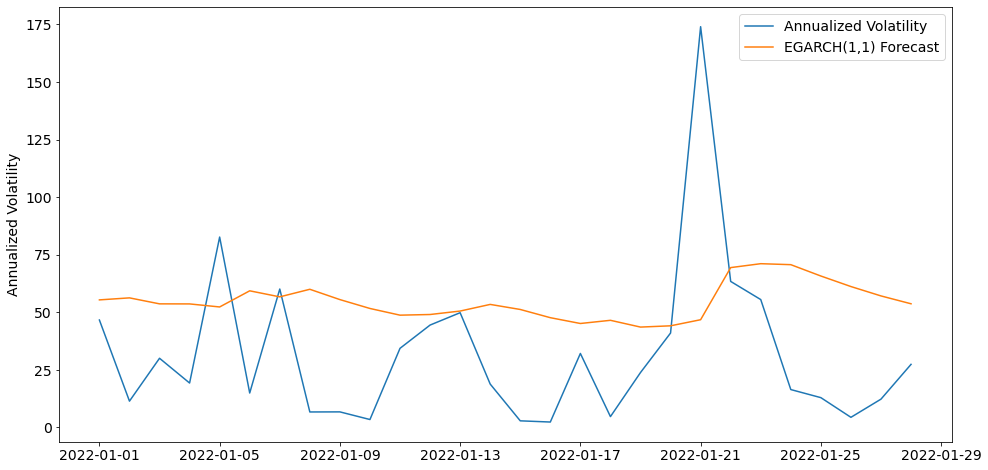

In [ ]:
plt.plot(np.sqrt(btc.iloc[-28:,2])*np.sqrt(252),label='Annualized Volatility')
plt.plot((btc.iloc[-28:,3]),label='EGARCH(1,1) Forecast')
plt.ylabel('Annualized Volatility')
plt.legend()


In [ ]:
f_errors = np.sqrt(btc.iloc[-28:,2])*np.sqrt(252) - btc.iloc[-28:,3]
f_errors.reset_index(drop=True,inplace=True)


In [ ]:
norm_ferrors= (f_errors - np.mean(f_errors))/np.std(f_errors)


<AxesSubplot:ylabel='Density'>

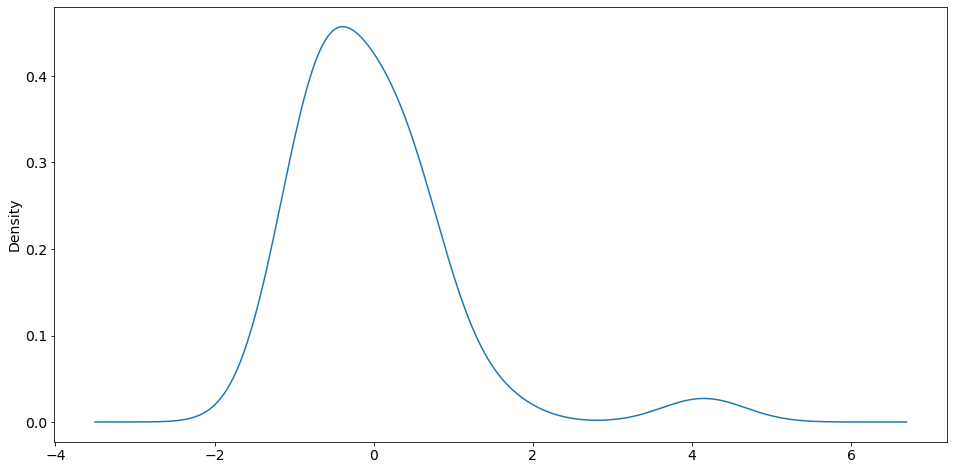

In [ ]:
norm_ferrors.plot.kde()